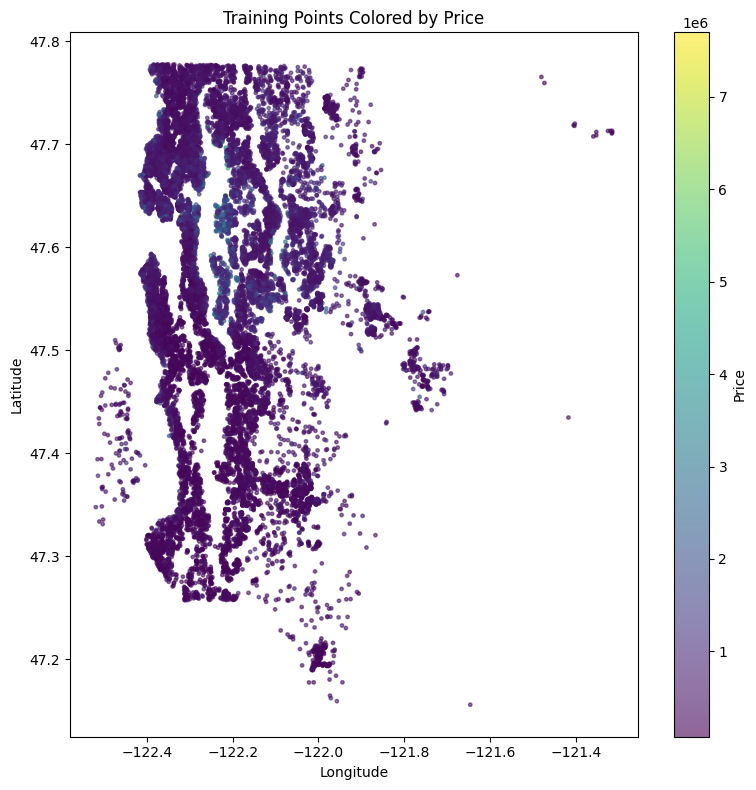

Saved: /workspaces/phdata_project/model/latlong_price_train.png


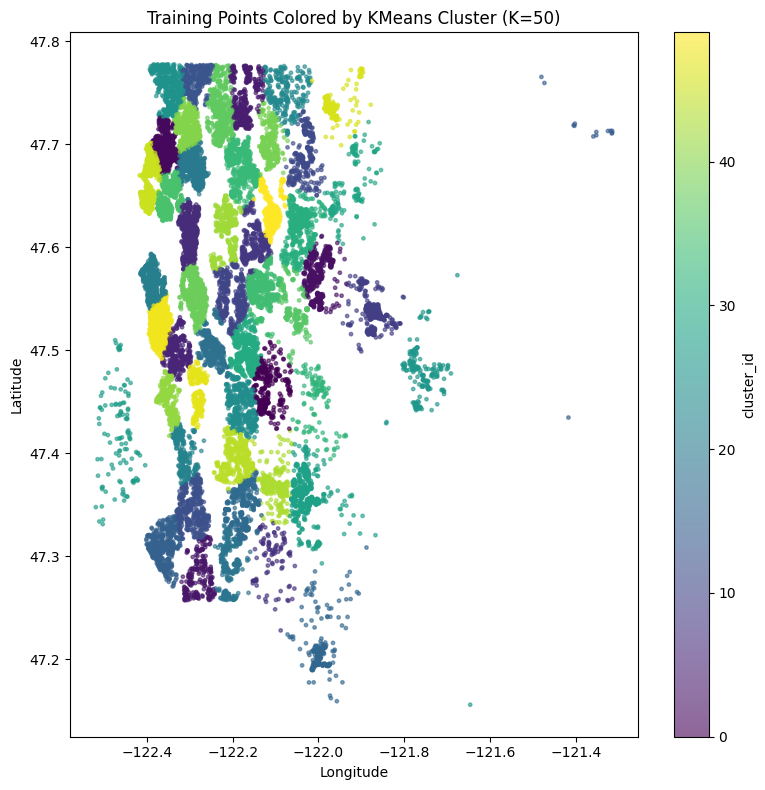

Saved: /workspaces/phdata_project/model/latlong_clusters_train.png


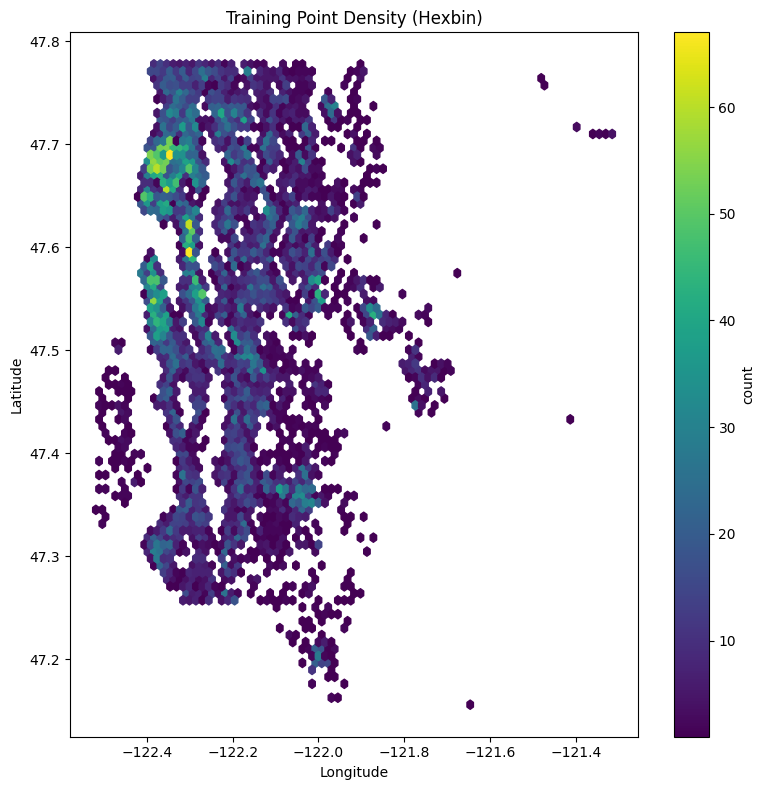

Saved: /workspaces/phdata_project/model/latlong_density_train.png


In [3]:
# Visualize training data points on lat/long (price, cluster_id, density)
# Run this in a notebook cell from the project root so relative paths match your train script.

from pathlib import Path
from typing import List, Tuple
import json

import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ---------- Config (mirrors your train_model.py) ----------
ROOT = Path(".").resolve()
DATA_DIR = ROOT / "data"
OUT_DIR = ROOT / "model"
OUT_DIR.mkdir(parents=True, exist_ok=True)

KMEANS_K = 50
KMEANS_RANDOM_STATE = 42

SALES_PATH = DATA_DIR / "kc_house_data.csv"
DEMOGRAPHICS_PATH = DATA_DIR / "zipcode_demographics.csv"

SALES_COLUMN_SELECTION: List[str] = [
    'price', 'sqft_living', 'bedrooms', 'sqft_lot', 'floors',
    'yr_built', 'yr_renovated', 'sqft_above', 'sqft_basement',
    'waterfront', 'view', 'condition', 'grade',
    'sqft_living15', 'bathrooms', 'sqft_lot15',
    'zipcode', 'lat', 'long'
]

DEMOGRAPHIC_COLUMN_SELECTION: List[str] = [
    'ppltn_qty','urbn_ppltn_qty','sbrbn_ppltn_qty','farm_ppltn_qty','non_farm_qty',
    'medn_hshld_incm_amt','medn_incm_per_prsn_amt','hous_val_amt',
    'edctn_less_than_9_qty','edctn_9_12_qty','edctn_high_schl_qty','edctn_some_clg_qty',
    'edctn_assoc_dgre_qty','edctn_bchlr_dgre_qty','edctn_prfsnl_qty',
    'per_urbn','per_sbrbn','per_farm','per_non_farm',
    'per_less_than_9','per_9_to_12','per_hsd','per_some_clg','per_assoc','per_bchlr','per_prfsnl',
    'zipcode'
]

def load_data(
    sales_path: Path,
    demographics_path: Path,
    sales_cols: List[str],
    demo_cols: List[str]
) -> Tuple[pd.DataFrame, pd.Series]:
    data = pd.read_csv(sales_path, usecols=sales_cols, dtype={'zipcode': str})
    demographics = pd.read_csv(demographics_path, usecols=demo_cols, dtype={'zipcode': str})
    merged = data.merge(demographics, how="left", on="zipcode").drop(columns="zipcode")
    y = merged.pop("price")
    X = merged
    return X, y

# ---------- Load & split ----------
X, y = load_data(SALES_PATH, DEMOGRAPHICS_PATH, SALES_COLUMN_SELECTION, DEMOGRAPHIC_COLUMN_SELECTION)
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.10, random_state=42
)

# ---------- Cluster on train lat/long (same idea as your training script) ----------
latlong_cols = ["lat", "long"]
assert all(c in x_train.columns for c in latlong_cols), "lat/long must be present"

scaler = StandardScaler()
scaler.fit(x_train[latlong_cols])

kmeans = KMeans(n_clusters=KMEANS_K, n_init="auto", random_state=KMEANS_RANDOM_STATE)
kmeans.fit(scaler.transform(x_train[latlong_cols]))

def add_cluster_id(df: pd.DataFrame) -> pd.Series:
    latlong_scaled = scaler.transform(df[latlong_cols])
    return pd.Series(kmeans.predict(latlong_scaled), index=df.index, name="cluster_id")

train_clusters = add_cluster_id(x_train)

# ---------- (1) Scatter by price (train only) ----------
# Downsample for legibility if very large
max_points = 20000
if len(x_train) > max_points:
    idx = np.random.RandomState(42).choice(x_train.index, size=max_points, replace=False)
else:
    idx = x_train.index

plt.figure(figsize=(8, 8))
sc = plt.scatter(
    x_train.loc[idx, "long"].values,
    x_train.loc[idx, "lat"].values,
    c=y_train.loc[idx].values,
    s=6,
    alpha=0.6
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Training Points Colored by Price")
cbar = plt.colorbar(sc)
cbar.set_label("Price")
price_png = OUT_DIR / "latlong_price_train.png"
plt.tight_layout()
plt.savefig(price_png, dpi=150)
plt.show()
print(f"Saved: {price_png}")

# ---------- (2) Scatter by cluster_id (train only) ----------
plt.figure(figsize=(8, 8))
sc2 = plt.scatter(
    x_train.loc[idx, "long"].values,
    x_train.loc[idx, "lat"].values,
    c=train_clusters.loc[idx].values,
    s=6,
    alpha=0.6
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Training Points Colored by KMeans Cluster (K={KMEANS_K})")
cbar2 = plt.colorbar(sc2)
cbar2.set_label("cluster_id")
cluster_png = OUT_DIR / "latlong_clusters_train.png"
plt.tight_layout()
plt.savefig(cluster_png, dpi=150)
plt.show()
print(f"Saved: {cluster_png}")

# ---------- (3) Density hexbin (train only) ----------
plt.figure(figsize=(8, 8))
hb = plt.hexbin(
    x_train["long"].values,
    x_train["lat"].values,
    gridsize=80,
    mincnt=1
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Training Point Density (Hexbin)")
cbar3 = plt.colorbar(hb)
cbar3.set_label("count")
hexbin_png = OUT_DIR / "latlong_density_train.png"
plt.tight_layout()
plt.savefig(hexbin_png, dpi=150)
plt.show()
print(f"Saved: {hexbin_png}")
